# BTC ML/DL Trading strategy

In [1]:
# Enabling the notebook execution from this sub-folder
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Importin utils global variables and methods
from src.Utils import *

## Preliminary data import & handling

In [3]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [5]:
# Deepcopying the dataset
df_ = df.copy(deep=True)

**Reference**:
1. https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [6]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [7]:
# Displaying column informations
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2136278 entries, 2018-01-01 00:01:00 to 2022-01-24 00:00:00
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Count   int32  
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
 6   VWAP    float64
dtypes: float64(6), int32(1)
memory usage: 122.2 MB


In [8]:
# Resampling to 10-min bins
df = df.resample("10T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="bfill", inplace=True)

# Deepcopying the dataset
df_sampled = df.copy(deep=True)

In [9]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,437.0,13835.194,14052.3,13501.01,13720.260,60.545301,13756.177556
2018-01-01 00:10:00,301.0,13713.610,13948.6,13400.01,13626.110,49.918511,13665.050348
2018-01-01 00:20:00,308.0,13626.248,13826.8,13410.44,13648.280,53.002165,13623.876888
2018-01-01 00:30:00,228.5,13638.620,13800.0,13461.74,13636.600,36.841839,13652.429477
2018-01-01 00:40:00,245.0,13649.296,13800.0,13450.00,13693.004,48.451182,13640.833680


In [10]:
# Some statistical analysis
df.describe().style.background_gradient(cmap='summer')

,Count,Open,High,Low,Close,Volume,VWAP
count,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000
mean,1036.575761,18706.849538,18780.568915,18636.490972,18706.957485,89.569931,18706.905651
std,1279.367076,17863.740822,17904.317644,17814.076700,17863.726108,114.678865,17863.725743
min,1.000000,3153.860000,3232.600000,3120.000000,3160.405000,0.001104,3159.199122
25%,318.000000,7124.448333,7159.000000,7098.480000,7124.657143,36.544792,7124.256692
50%,614.000000,9504.030000,9530.000000,9476.660000,9503.897143,57.727493,9503.429433
75%,1311.500000,32225.492857,32361.000000,32084.715549,32225.264388,98.577041,32221.782272
max,55717.500000,68716.598333,69024.200000,68447.000000,68724.006667,3985.862343,68619.267512


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [11]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [12]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

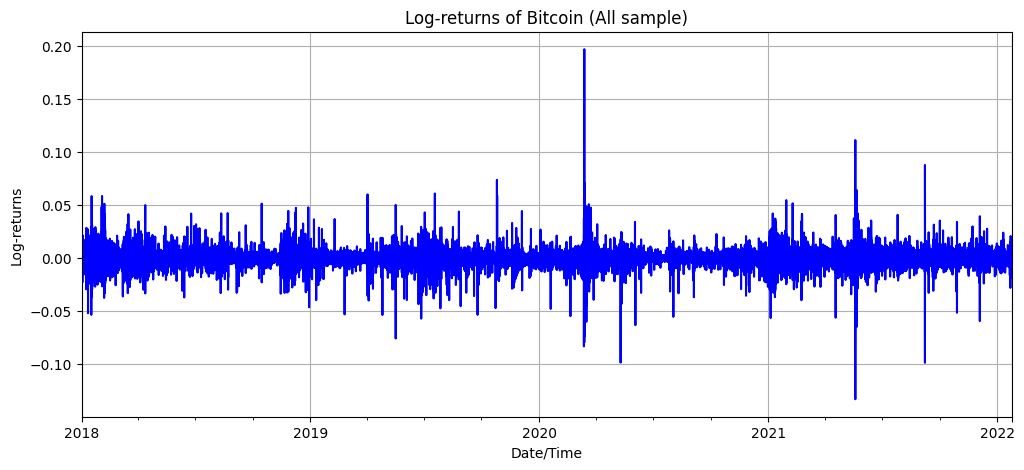

In [13]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

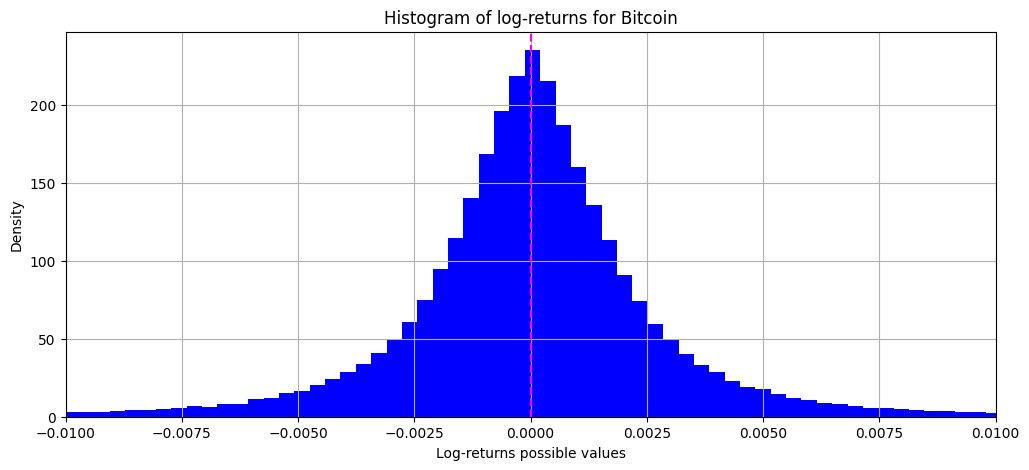

In [15]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [16]:
def rsi(df, periods = 10, ema = True):
    """
    Returns a pd.Series with the Relative Strength Index (RSI)
    ==> Technical analysis indicator (see report)
    """
    # Computing the Close price delta
    close_delta = df["Close"].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
    
    # Computing the RSI
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [17]:
# Computing Rolled average close price
df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = rsi(df)

# Computing the Bollinger Bands (BB) indicators
#upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
#                                          nbdevup=2,
#                                          nbdevdn=2,
#                                          timeperiod=20)
#df["BBANDS_U"] = upper_2sd
#df["BBANDS_M"] = mid_2sd
#df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

# TODO: Adding other technical analysis indicator
# Momentum
# Standard deviation
# ...

In [18]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

18

In [19]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,
2018-01-01 03:00:00,210.5,13410.248,13576.4,13290.00,13417.166,25.320077,13413.113599,5,0.000275,13405.6110,0.370744,-3.224,-8.622,41.116585,13388.0464,13405.6110,13480.037867
2018-01-01 03:10:00,352.5,13417.998,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,13403.3596,-0.380974,0.832,7.750,54.431361,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,13423.3538,-0.556381,1.134,127.054,60.915374,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,13446.0278,-0.475076,5.858,88.418,54.352457,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,13459.2326,-0.490321,-1.898,-71.676,52.943308,13540.3736,13459.2326,13463.470800


### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [20]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,
2018-01-01 03:00:00,210.5,13410.248,13576.4,13290.00,13417.166,25.320077,13413.113599,5,0.000275,13405.6110,0.370744,-3.224,-8.622,41.116585,13388.0464,13405.6110,13480.037867
2018-01-01 03:10:00,352.5,13417.998,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,13403.3596,-0.380974,0.832,7.750,54.431361,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,13423.3538,-0.556381,1.134,127.054,60.915374,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,13446.0278,-0.475076,5.858,88.418,54.352457,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,13459.2326,-0.490321,-1.898,-71.676,52.943308,13540.3736,13459.2326,13463.470800


In [21]:
# Computation of the target
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

In [24]:
# X/Y split - Splitting the dataset into X/Y
# X = features, 
# Y = target
#X = df.copy() # X as a deep copy for security reason
#Y = X.pop("Target")

In [22]:
correlation_matrix = df.corr()
df.corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,SMA_SLOW,SMA_MEDIUM,SMA_FAST,Target
Count,1.000000,0.549672,0.551852,0.546709,0.549534,0.617805,0.549552,-0.012574,-0.022761,0.550549,0.145739,0.013761,-0.061912,-0.037562,0.550006,0.550549,0.550949,0.003868
Open,0.549672,1.000000,0.999984,0.999975,0.999986,-0.007648,0.999995,0.000377,-0.001676,0.999974,0.034513,0.009059,0.003039,0.006664,0.999992,0.999974,0.999954,-0.007791
High,0.551852,0.999984,1.000000,0.999953,0.999985,-0.005768,0.999988,0.000346,0.000483,0.999964,0.034853,0.009319,0.002738,0.007322,0.999981,0.999964,0.999946,-0.007841
Low,0.546709,0.999975,0.999953,1.000000,0.999978,-0.010271,0.999981,0.000362,0.000802,0.999943,0.034097,0.009059,0.003540,0.007968,0.999967,0.999943,0.999920,-0.007906
Close,0.549534,0.999986,0.999985,0.999978,1.000000,-0.007812,0.999996,0.000360,0.002316,0.999964,0.034520,0.009251,0.002920,0.008122,0.999984,0.999964,0.999944,-0.007944
Volume,0.617805,-0.007648,-0.005768,-0.010271,-0.007812,1.000000,-0.007774,-0.027807,-0.047458,-0.007074,0.198422,0.010254,-0.047858,-0.038623,-0.007424,-0.007074,-0.006842,0.009680
VWAP,0.549552,0.999995,0.999988,0.999981,0.999996,-0.007774,1.000000,0.000372,0.000422,0.999971,0.034512,0.009211,0.002963,0.007453,0.999990,0.999971,0.999951,-0.007859
TimeRange,-0.012574,0.000377,0.000346,0.000362,0.000360,-0.027807,0.000372,1.000000,-0.003084,0.000420,-0.003936,0.000967,-0.002453,0.007776,0.000390,0.000420,0.000437,0.000906
LogReturns,-0.022761,-0.001676,0.000483,0.000802,0.002316,-0.047458,0.000422,-0.003084,1.000000,-0.001116,-0.000845,0.103813,-0.012756,0.360790,-0.000799,-0.001116,-0.001211,-0.052240
Rolled_Avg_Close,0.550549,0.999974,0.999964,0.999943,0.999964,-0.007074,0.999971,0.000420,-0.001116,1.000000,0.034577,0.008882,-0.000987,0.003285,0.999989,1.000000,0.999993,-0.007574


In [23]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['High', 'Low', 'Close', 'VWAP', 'Rolled_Avg_Close', 'SMA_SLOW', 'SMA_MEDIUM', 'SMA_FAST']


In [33]:
list(df.columns)

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'TimeRange',
 'LogReturns',
 'RSI',
 'SMA_SLOW',
 'Target']

In [25]:
# Drop highly correlated features
to_drop = ["Open", "High", "Low", "VWAP", "SMA_SLOW"] # "Rolled_Avg_Close", "BBANDS_U", "BBANDS_M", "BBANDS_L", "SMA_MEDIUM", "SMA_FAST"
try:
    if len(to_drop) != 0:
        df.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except KeyError as e:
    print("High-correlated features already removed")

Removing high-correlated columns


In [422]:
# Outliers detection + removing (Winsorize methods)

In [84]:
# Confusion matrix + see report on + Intro ML Bologna

In [24]:
df.corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,SMA_SLOW,SMA_MEDIUM,SMA_FAST,Target
Count,1.000000,0.549672,0.551852,0.546709,0.549534,0.617805,0.549552,-0.012574,-0.022761,0.550549,0.145739,0.013761,-0.061912,-0.037562,0.550006,0.550549,0.550949,0.003868
Open,0.549672,1.000000,0.999984,0.999975,0.999986,-0.007648,0.999995,0.000377,-0.001676,0.999974,0.034513,0.009059,0.003039,0.006664,0.999992,0.999974,0.999954,-0.007791
High,0.551852,0.999984,1.000000,0.999953,0.999985,-0.005768,0.999988,0.000346,0.000483,0.999964,0.034853,0.009319,0.002738,0.007322,0.999981,0.999964,0.999946,-0.007841
Low,0.546709,0.999975,0.999953,1.000000,0.999978,-0.010271,0.999981,0.000362,0.000802,0.999943,0.034097,0.009059,0.003540,0.007968,0.999967,0.999943,0.999920,-0.007906
Close,0.549534,0.999986,0.999985,0.999978,1.000000,-0.007812,0.999996,0.000360,0.002316,0.999964,0.034520,0.009251,0.002920,0.008122,0.999984,0.999964,0.999944,-0.007944
Volume,0.617805,-0.007648,-0.005768,-0.010271,-0.007812,1.000000,-0.007774,-0.027807,-0.047458,-0.007074,0.198422,0.010254,-0.047858,-0.038623,-0.007424,-0.007074,-0.006842,0.009680
VWAP,0.549552,0.999995,0.999988,0.999981,0.999996,-0.007774,1.000000,0.000372,0.000422,0.999971,0.034512,0.009211,0.002963,0.007453,0.999990,0.999971,0.999951,-0.007859
TimeRange,-0.012574,0.000377,0.000346,0.000362,0.000360,-0.027807,0.000372,1.000000,-0.003084,0.000420,-0.003936,0.000967,-0.002453,0.007776,0.000390,0.000420,0.000437,0.000906
LogReturns,-0.022761,-0.001676,0.000483,0.000802,0.002316,-0.047458,0.000422,-0.003084,1.000000,-0.001116,-0.000845,0.103813,-0.012756,0.360790,-0.000799,-0.001116,-0.001211,-0.052240
Rolled_Avg_Close,0.550549,0.999974,0.999964,0.999943,0.999964,-0.007074,0.999971,0.000420,-0.001116,1.000000,0.034577,0.008882,-0.000987,0.003285,0.999989,1.000000,0.999993,-0.007574


In [129]:
# GridSearch on model with the 5-10 best features

In [25]:
LAGGED_SERIES = list(range(1, 20))
for lag in LAGGED_SERIES:
    df[f"Close (t - {lag})"] = df["Close"].shift(periods=lag)
    df[f"Target (t - {lag})"] = df["Target"].shift(periods=lag)
    df[f"RSI (t - {lag})"] = df["RSI"].shift(periods=lag)
# Dropping newly-created NaN values
df.dropna(inplace=True)

In [26]:
# Getting initial dataset (subset of time range)
btc_2018 = df["2018-01": "2018-04"]

In [27]:
btc_2018

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,...,RSI (t - 16),Close (t - 17),Target (t - 17),RSI (t - 17),Close (t - 18),Target (t - 18),RSI (t - 18),Close (t - 19),Target (t - 19),RSI (t - 19)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:10:00,192.5,13554.496000,13850.0,13452.00,13580.914000,34.977116,13559.859902,0,0.003107,13589.626000,...,54.352457,13627.612000,0.0,60.915374,13543.918000,1.0,54.431361,13417.166000,1.0,41.116585
2018-01-01 06:20:00,340.5,13583.240000,14000.0,13473.08,13715.620000,54.654752,13681.354901,0,0.009870,13599.855400,...,52.943308,13563.692000,0.0,54.352457,13627.612000,0.0,60.915374,13543.918000,1.0,54.431361
2018-01-01 06:30:00,209.5,13719.510000,14000.0,13602.53,13718.398000,24.363162,13709.096355,0,0.000203,13606.389000,...,47.851783,13549.480000,0.0,52.943308,13563.692000,0.0,54.352457,13627.612000,0.0,60.915374
2018-01-01 06:40:00,260.0,13718.238000,14442.9,13644.99,13801.032000,49.739558,13780.980585,0,0.006006,13626.582200,...,44.706537,13496.986000,0.0,47.851783,13549.480000,0.0,52.943308,13563.692000,0.0,54.352457
2018-01-01 06:50:00,278.5,13801.034000,14141.0,13713.26,13868.724000,54.396066,13859.155262,0,0.004893,13649.835600,...,40.820024,13462.424000,0.0,44.706537,13496.986000,0.0,47.851783,13549.480000,0.0,52.943308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-30 23:10:00,360.0,9212.412000,9250.0,9181.33,9213.765000,60.863333,9215.946174,4,0.000454,9225.639506,...,46.858398,9307.681667,0.0,47.545054,9327.812000,0.0,59.703524,9324.134000,1.0,57.934631
2018-04-30 23:20:00,280.0,9213.950000,9237.7,9189.71,9223.484000,64.800272,9215.091222,4,0.001054,9225.518506,...,44.616087,9306.378000,0.0,46.858398,9307.681667,0.0,47.545054,9327.812000,0.0,59.703524
2018-04-30 23:30:00,222.5,9223.408333,9240.9,9206.97,9229.543333,29.943373,9226.764245,4,0.000657,9226.572006,...,31.054054,9302.295000,0.0,44.616087,9306.378000,0.0,46.858398,9307.681667,0.0,47.545054


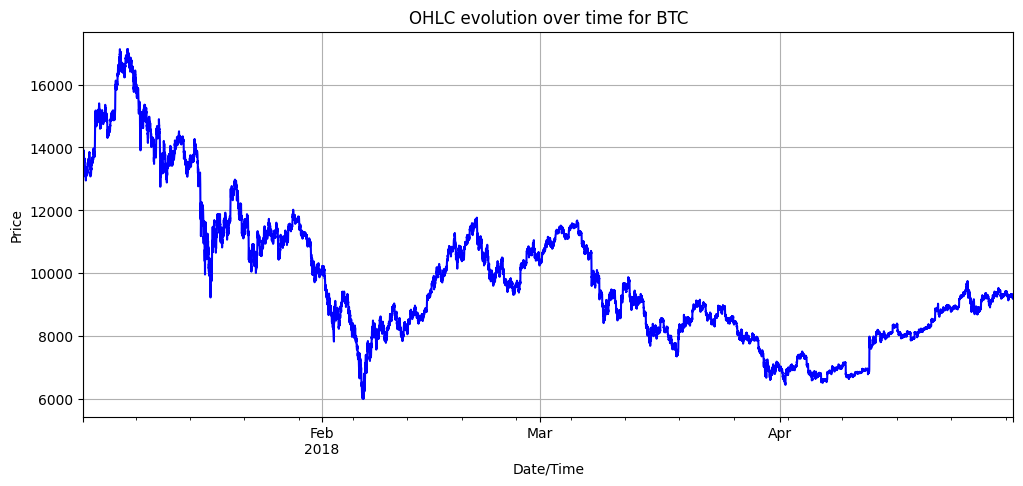

In [28]:
# Plotting OHLC time series
_ = btc_2018["Close"].plot()
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Price")
_ = plt.title("OHLC evolution over time for BTC")

In [29]:
# Getting DataFrame shape
nb_obs, nb_cols = btc_2018.shape
print(f"Number of 10-min bins:\t {nb_obs}\nNumber of columns:\t {nb_cols}")

Number of 10-min bins:	 17243
Number of columns:	 75


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import *
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [35]:
# Removing old model files
files = glob.glob("../out/models/model_*")
for f in files:
    os.remove(f)

In [36]:
# Test on WF

# Splitting X/Y
X = btc_2018.copy() # X as a deep copy for security reason
Y = X.pop("Target")

# Defining the number of train points and number of records
n_train = 5_000
n_records = 5_300 #len(btc_2018)//2

# Declaring the main model
model = XGBClassifier(learning_rate=0.03, n_estimators=200, max_depth=4, max_leaves=3, objective='binary:logistic') #, booster='gbtree')

# Model name (on-disk storage)
MODEL_NAME = f"../out/models/model_{0}"

# Horizon lags
HORIZON_LAGS = {
    "future": 10, # 15
    "past": 50 # None
}

# Metrics
METRICS = {
    "train_size": {}, # Shape of the train set
    "test_size": {}, # Shape of the test set
    "exec_time": {}, # Execution (fitting + prediction) time
    "model_size": {} # File size of the on-disk model
}

# Predictions dataframes
preds_cols = ["ts"] + [str(i) for i in range(1, HORIZON_LAGS["future"] + 1)] + ["conf_mat"] + ["report"]
preds = pd.DataFrame(columns=preds_cols)

# Looping over each time t
for k, i in enumerate(range(n_train, n_records)):
    print(k, "--", i)
    
    # Train/test split for X
    X_train = X.iloc[0: i] # X.iloc[i - HORIZON_LAGS["past"]: i] # 0: i
    X_test = X.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Getting the current datetime
    dt_now = list(X_train.index)[-1]
    
    # Defining the scaler pre-processor
    scaler = MinMaxScaler() # StandardScaler()
    
    # Scaling X_train
    X_train_scaled = scaler.fit_transform(X_train)
    # - None: XGBoost model fitting with X_train_scaled & Y_train
    # - X_test_scaled: Scaling of X_test using this scaler with input as X_test
    # - Y_pred: XGBoost model prediction with input X_test_scaled
    
    # Saving lengths
    METRICS["train_size"][dt_now] = len(X_train)
    METRICS["test_size"][dt_now] = len(X_test)

    # Train/test split for Y
    Y_train = Y.iloc[0: i] # Y.iloc[i - HORIZON_LAGS["past"]: i] # 0: i
    Y_test = Y.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Timing the fitting & prediction operations
    start_time = time.time()
    
    # If first iteration, only fit
    if k == 0:
        model.fit(X=X_train, y=Y_train) # or X_train_scaled
    else:        
        # If next iterations, fitting using previous knowledge (saved on-disk)
        model.fit(X=X_train, y=Y_train, xgb_model=MODEL_NAME) # or X_train_scaled
    
    # Model name (on-disk storage) ==> Use the k-th counter to track iterations on MODEL_NAME to re-use fit
    MODEL_NAME = f"../out/models/model_{k}"
    
    # Saving the model for incremental learning (growing filtration)
    model.get_booster().save_model(MODEL_NAME)
    
    # Scaling the X_test dataset with the scaler trained on X_train
    X_test_scaled = scaler.transform(X_test)
    
    # Predicting the HORIZON_LAGS["future"] market movements from dt_now
    Y_pred = model.predict(X=X_test) # or X_test_scaled
    #print(Y_pred)
    
    if k == 0:
        METRICS["model_size"][dt_now] = 0.0
    else:
        METRICS["model_size"][dt_now] = os.path.getsize(MODEL_NAME)/1e6
    
    # Storing the duration time for fitting step
    dur_time = time.time() - start_time
    METRICS["exec_time"][dt_now] = dur_time
    print(f"Exec. time: {dur_time:.3f}s")
    
    # Computing the confusion matrix
    conf_mat = confusion_matrix(y_true=list(Y_test.values), y_pred=list(Y_pred))
    
    # Getting classification report
    clf_report = classification_report(y_true=Y_test, y_pred=Y_pred, output_dict=True)
    
    # Appending the predictions
    preds = preds.append(pd.DataFrame([[dt_now] + list(Y_pred) + [conf_mat] + [clf_report]], columns=preds_cols), ignore_index=True)
    
    #print(train.shape, test.shape)

0 -- 5000
Exec. time: 1.436s
1 -- 5001
Exec. time: 1.432s
2 -- 5002
Exec. time: 1.609s
3 -- 5003
Exec. time: 1.489s
4 -- 5004
Exec. time: 1.498s
5 -- 5005
Exec. time: 1.498s
6 -- 5006
Exec. time: 1.518s
7 -- 5007
Exec. time: 1.546s
8 -- 5008
Exec. time: 1.639s
9 -- 5009
Exec. time: 1.680s
10 -- 5010
Exec. time: 1.629s
11 -- 5011
Exec. time: 1.716s
12 -- 5012
Exec. time: 1.870s
13 -- 5013
Exec. time: 1.903s
14 -- 5014
Exec. time: 1.803s
15 -- 5015
Exec. time: 1.822s
16 -- 5016
Exec. time: 1.872s
17 -- 5017
Exec. time: 1.965s
18 -- 5018
Exec. time: 1.875s
19 -- 5019
Exec. time: 1.978s
20 -- 5020
Exec. time: 1.883s
21 -- 5021
Exec. time: 2.015s
22 -- 5022
Exec. time: 2.007s
23 -- 5023
Exec. time: 2.205s
24 -- 5024
Exec. time: 1.965s
25 -- 5025
Exec. time: 2.123s
26 -- 5026
Exec. time: 2.259s
27 -- 5027
Exec. time: 2.008s
28 -- 5028
Exec. time: 2.070s
29 -- 5029
Exec. time: 2.127s
30 -- 5030
Exec. time: 2.084s
31 -- 5031
Exec. time: 2.101s
32 -- 5032
Exec. time: 2.035s
33 -- 5033
Exec. tim

Exec. time: 3.455s
269 -- 5269
Exec. time: 3.322s
270 -- 5270
Exec. time: 3.243s
271 -- 5271
Exec. time: 3.284s
272 -- 5272
Exec. time: 3.295s
273 -- 5273
Exec. time: 3.534s
274 -- 5274
Exec. time: 3.352s
275 -- 5275
Exec. time: 3.343s
276 -- 5276
Exec. time: 3.276s
277 -- 5277
Exec. time: 3.291s
278 -- 5278
Exec. time: 3.285s
279 -- 5279
Exec. time: 3.315s
280 -- 5280
Exec. time: 3.376s
281 -- 5281
Exec. time: 3.431s
282 -- 5282
Exec. time: 3.435s
283 -- 5283
Exec. time: 3.594s
284 -- 5284
Exec. time: 3.684s
285 -- 5285
Exec. time: 3.743s
286 -- 5286
Exec. time: 3.725s
287 -- 5287
Exec. time: 3.403s
288 -- 5288
Exec. time: 3.389s
289 -- 5289
Exec. time: 3.407s
290 -- 5290
Exec. time: 3.659s
291 -- 5291
Exec. time: 3.548s
292 -- 5292
Exec. time: 3.622s
293 -- 5293
Exec. time: 3.894s
294 -- 5294
Exec. time: 3.522s
295 -- 5295
Exec. time: 3.615s
296 -- 5296
Exec. time: 3.795s
297 -- 5297
Exec. time: 3.762s
298 -- 5298
Exec. time: 3.516s
299 -- 5299
Exec. time: 3.577s


**References**:
1. https://greyhoundanalytics.com/blog/backtestingpy-a-complete-quickstart-guide/
2. https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot
3. https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [37]:
# Broadcasting into a Pandas DataFrame
METRICS_ = pd.DataFrame(METRICS)

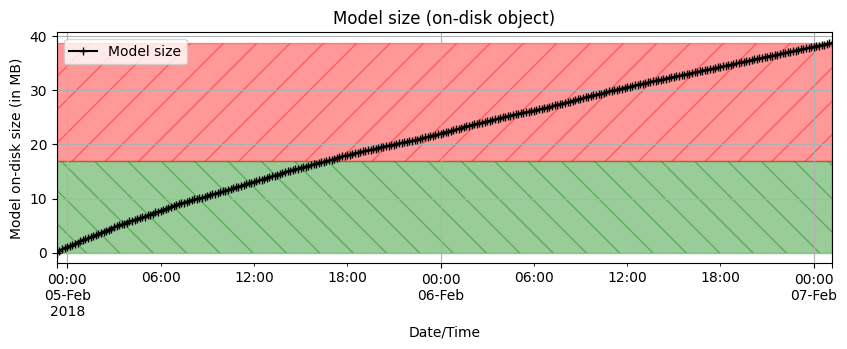

In [38]:
# Plotting model file size
_ = METRICS_["model_size"].plot(marker="+", label="Model size", figsize=(10, 3), color="black")
threshold_ = 17
_ = plt.axhspan(ymin=METRICS_["model_size"].min(), ymax=threshold_, color="green", hatch="\\", alpha=0.4)
_ = plt.axhspan(ymin=threshold_, ymax=METRICS_["model_size"].max(), color="red", hatch="/", alpha=0.4)
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Model on-disk size (in MB)")
_ = plt.title("Model size (on-disk object)")
_ = plt.legend()

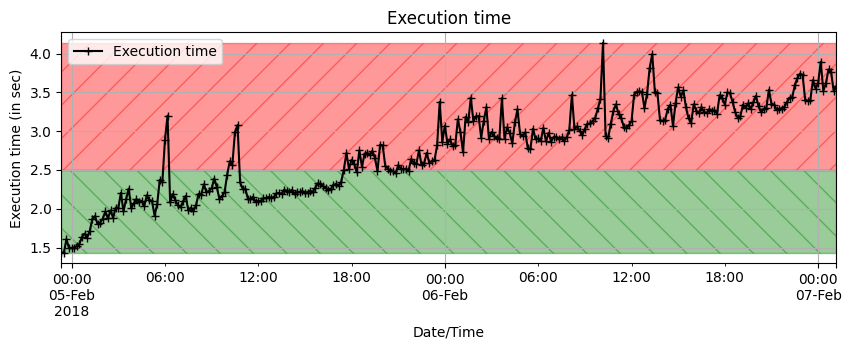

In [39]:
# Plotting exec. time for each fitting step
_ = METRICS_["exec_time"].plot(marker="+", label="Execution time", figsize=(10, 3), color="black")
threshold_ = 2.5
_ = plt.axhspan(ymin=METRICS_["exec_time"].min(), ymax=threshold_, color="green", hatch="\\", alpha=0.4)
_ = plt.axhspan(ymin=threshold_, ymax=METRICS_["exec_time"].max(), color="red", hatch="/", alpha=0.4)
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Execution time (in sec)")
_ = plt.title("Execution time")
_ = plt.legend()

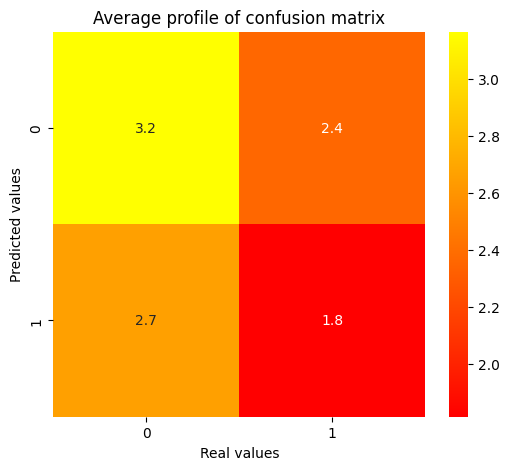

In [40]:
# Getting the 
_ = plt.figure(figsize=(6, 5))
_ = sns.heatmap(preds["conf_mat"].mean(), annot=True, cmap="autumn")
_ = plt.title("Average profile of confusion matrix")
_ = plt.xlabel("Real values")
_ = plt.ylabel("Predicted values")

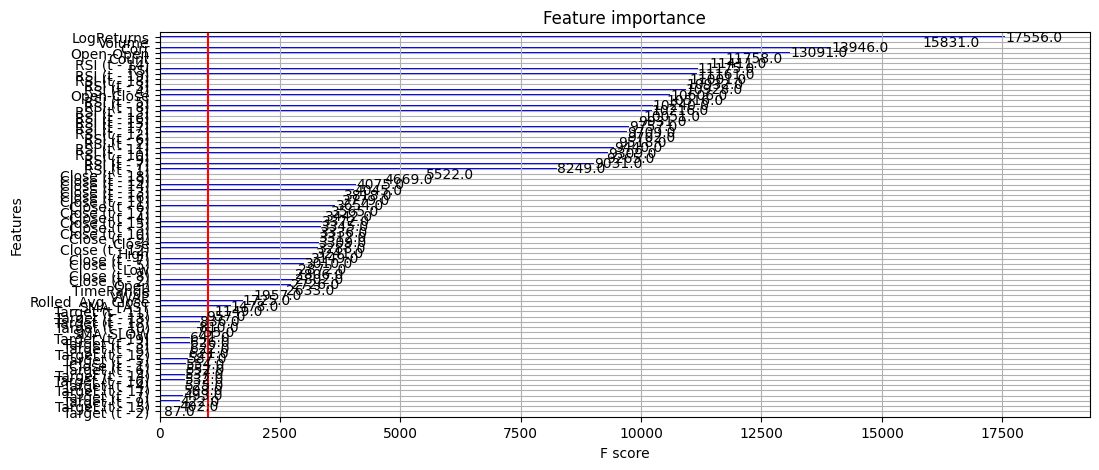

In [45]:
# Plot features 
_ = plot_importance(booster=model.get_booster())
_ = plt.axvline(x = 1000, color="red")

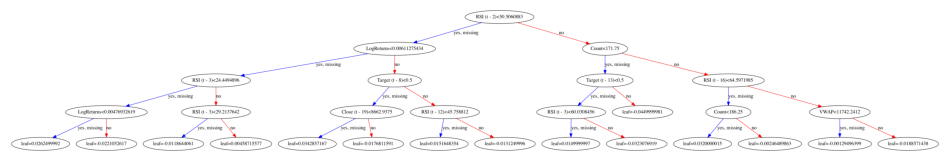

In [46]:
_ = plot_tree(booster=model.get_booster())

In [75]:
# Defining the trading strategy
import datetime
import xgboost
import pandas_ta as tap
import pandas as pd
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import EURUSD
from backtesting.lib import resample_apply

In [76]:
# Dataset
#btc_2018 = df["2018-01": "2018-04"]

In [78]:
preds.head()

,ts,1,2,3,4,5,6,7,8,9,10,conf_mat,report
0,2018-02-04 23:20:00,1,1,1,1,1,0,1,1,1,1,"[[1, 7], [0, 2]]","{'0': {'precision': 1.0, 'recall': 0.125, 'f1-..."
1,2018-02-04 23:30:00,1,1,1,1,0,1,1,1,1,1,"[[1, 7], [0, 2]]","{'0': {'precision': 1.0, 'recall': 0.125, 'f1-..."
2,2018-02-04 23:40:00,1,1,1,0,1,1,1,1,1,1,"[[1, 6], [0, 3]]","{'0': {'precision': 1.0, 'recall': 0.142857142..."
3,2018-02-04 23:50:00,1,1,0,1,1,1,1,1,1,0,"[[2, 6], [0, 2]]","{'0': {'precision': 1.0, 'recall': 0.25, 'f1-s..."
4,2018-02-05 00:00:00,1,1,1,1,1,1,1,1,0,1,"[[1, 7], [0, 2]]","{'0': {'precision': 1.0, 'recall': 0.125, 'f1-..."


In [70]:
# Defining the strategy
class RsiOscillator(Strategy):
    """
    Class Strategy
    """
    upper_bound = 70
    lower_bound = 30
    rsi_window = 3

    # Do as much initial computation as possible
    def init(self):
        self.daily_rsi = self.I(tap.rsi, pd.Series(self.data.Close), self.rsi_window)
    
    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        #print(len(self.data.df))
        price = self.data.df.iloc[-1]
        #print(type(price))
        
        print(len(self.daily_rsi))
        # Use the history (thanks to the I (indicator function)) + 
        # Use the prediction for the l (future lag) next 10 iterations from now on 
        # To do so, we are taking the current_dt and adding the delta (l: future lag to get a dataframe/series
        # with our different predicted models (binary target and/or another ))
        # For instance, check whether we have an increasing/decreasing trend for the next values
        
        current_dt = price.name
        #print(current_dt, price["Close"])
        #print("---")
        self.hello_world()
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()
        # Check crossover
        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy()

In [71]:
class BT(Backtest):
    def __init__(self, *args, **kwargs):
        print("Initializing the backtest instance ...")
        super().__init__(*args, **kwargs)
        self._strategy.hello_world = lambda x: x == 1
    
    def run(self, *args, **kwargs):
        print("Running ...")
        return super().run(*args, **kwargs)

In [72]:
bt = BT(btc_2018[0: 40000], RsiOscillator, cash=20_000, commission=.002)

Initializing the backtest instance ...


In [73]:
# Defining the backtesting object for the given strategy
#bt = Backtest(btc_2018[0: 10000], RsiOscillator, cash=10_000, commission=.002)

In [74]:
# Running the backtesting operation
stats = bt.run()

Running ...
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267


4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265


5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100


7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752


10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
10526
10527
10528
10529
10530
10531
10532
10533
10534
10535
10536
10537
10538
10539
10540
10541
10542
10543
10544
10545
10546
10547
10548
10549
10550
10551
10552
10553
10554
10555
10556
10557
10558
10559
10560
10561
10562
10563
10564
10565
10566
10567
10568
10569
10570
10571
10572
10573
10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
1059

12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
1255

14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
1444

15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
1600

In [65]:
# Defining the current timestamp (string representation)
dt_now = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")

# Plotting the results curves (in the Jupyter notebook)
_ = bt.plot()

# Saving on-disk the results curves as HTML page
#_ = bt.plot(filename=f"../out/backtests/plots/plots_{dt_now}")

# Collecting statistical output from backtest
bt_results = stats

In [66]:
# Getting the statistical output from backtest (broadcasting into a Python dict from a BT stat type)
bt_results_ = {k:v for k, v in bt_results.items() if k not in ["_trades", "_equity_curve", "_strategy"]}

# Getting the output strategy instance
bt_strategy = bt_results["_strategy"]

# Getting the equity curve
bt_equity_curve = bt_results["_equity_curve"]

# Getting the trades table
bt_trades = bt_results["_trades"]

In [67]:
# Saving on-disk 
bt_trades.to_csv(f"../out/backtests/trades/trades_{dt_now}.csv")
bt_equity_curve.to_csv(f"../out/backtests/equity_curves/ec_{dt_now}.csv")

In [68]:
bt_results_

{'Start': Timestamp('2018-01-01 06:10:00'),
 'End': Timestamp('2018-04-30 23:50:00'),
 'Duration': Timedelta('119 days 17:40:00'),
 'Exposure Time [%]': 34.24578089659572,
 'Equity Final [$]': 6916.185534246237,
 'Equity Peak [$]': 20387.879825325992,
 'Return [%]': -65.4190723287688,
 'Buy & Hold Return [%]': -31.94005940984532,
 'Return (Ann.) [%]': -95.87879236413562,
 'Volatility (Ann.) [%]': 2.636837697417608,
 'Sharpe Ratio': 0.0,
 'Sortino Ratio': 0.0,
 'Calmar Ratio': 0.0,
 'Max. Drawdown [%]': -67.54497622638182,
 'Avg. Drawdown [%]': -10.428752021820873,
 'Max. Drawdown Duration': Timedelta('117 days 15:10:00'),
 'Avg. Drawdown Duration': Timedelta('17 days 02:15:00'),
 '# Trades': 540,
 'Win Rate [%]': 57.22222222222222,
 'Best Trade [%]': 4.176706345465342,
 'Worst Trade [%]': -9.179780036069364,
 'Avg. Trade [%]': -0.22229721869628793,
 'Max. Trade Duration': Timedelta('0 days 08:40:00'),
 'Avg. Trade Duration': Timedelta('0 days 01:40:00'),
 'Profit Factor': 0.68759384958

In [416]:
btc_2018[:][2:26]

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:40:00,260.0,13718.2380,14442.9,13644.990000,13801.032000,49.739558,13780.980585,0,0.006006,1,...,0.665895,-0.160000,-1.2720,74.396604,13759.686806,13586.581100,13413.475394,13670.950800,13626.582200,13616.111600
2018-01-01 06:50:00,278.5,13801.0340,14141.0,13713.260000,13868.724000,54.396066,13859.155262,0,0.004893,1,...,0.881893,0.002000,82.7960,78.243280,13813.613911,13601.832700,13390.051489,13736.937600,13649.835600,13638.266533
2018-01-01 07:00:00,296.0,13865.9440,14224.0,13738.980000,13917.490000,26.822479,13888.212163,0,0.003510,0,...,0.941397,-2.780000,64.9100,80.578886,13870.985494,13620.233200,13369.480906,13804.252800,13681.119400,13661.168267
2018-01-01 07:10:00,273.5,13928.5560,14200.0,13600.000000,13784.644000,37.799960,13852.301551,0,-0.009591,1,...,0.819162,11.066000,62.6120,60.817291,13888.422029,13634.616100,13380.810171,13818.057600,13704.379400,13672.589467
2018-01-01 07:20:00,157.5,13789.4440,14052.6,13605.090000,13811.102000,30.676385,13794.868481,0,0.001918,0,...,0.739362,4.800000,-139.1120,62.834305,13904.044279,13652.050000,13400.055721,13836.598400,13729.039200,13683.125467
2018-01-01 07:30:00,170.5,13798.3620,14123.0,13650.000000,13786.030000,21.834104,13811.795528,0,-0.001817,0,...,0.628951,-12.740000,8.9180,59.603747,13904.399418,13670.483200,13436.566982,13833.598000,13752.274400,13695.587467
2018-01-01 07:40:00,218.0,13789.5480,14030.1,13555.980000,13688.578000,47.322837,13725.840631,0,-0.007094,0,...,0.299656,3.518000,-8.8140,48.773794,13903.824329,13678.092100,13452.359871,13797.568800,13767.253200,13699.080000
2018-01-01 07:50:00,168.5,13691.3080,14060.0,13555.020000,13682.164000,22.559285,13694.412312,0,-0.000469,0,...,-0.196369,2.730000,-98.2400,48.134203,13904.121117,13683.502100,13462.883083,13750.503600,13777.378200,13704.247467
2018-01-01 08:00:00,164.0,13680.1860,14120.4,13520.000000,13620.555000,20.852116,13648.916404,0,-0.004513,1,...,-0.496338,-1.978000,-11.1220,42.224649,13904.044745,13683.863550,13463.682355,13717.685800,13767.871700,13708.814867


In [419]:
X[:].iloc[-1].name

Timestamp('2022-01-24 00:00:00', freq='10T')